In [5]:
import pandas as pd

In [6]:
import os
if os.path.exists("ghost_generics.csv.gz"):
    ghost_df = pd.read_csv("ghost_generics.csv.gz", compression='gzip')
else:
    raise
    ghost_df = pd.read_gbq("""
SELECT
  prac.ccg_id,
  rx.practice_code,
  rx.bnf_code,
  rx.bnf_description,
  rx.items,
  rx.quantity,
  rx.nic,
  dt.concession,
  dt.quantity AS dt_quantity,
  dt.price_pence,
  SUM(rx.items*rx.quantity) AS QI,
  ROUND(IEEE_DIVIDE(rx.NIC, (rx.items*rx.quantity)),4) AS rx_ppu,
  ROUND(IEEE_DIVIDE((dt.price_pence/100), dt.quantity),4) AS dt_ppu,
  CASE
    WHEN dt.concession IS NOT NULL THEN ROUND(IEEE_DIVIDE((dt.concession/100), dt.quantity), 4)
    ELSE NULL
  END AS concession_ppu
FROM
  richard.prescribing_2018_09_full AS rx
JOIN
  dmd.dt_viewer AS dt
ON
  rx.bnf_code=dt.bnf_code
JOIN
  hscic.practices AS prac
ON
  rx.practice_code=prac.code
WHERE
  (rx.bnf_description LIKE '%_Tab%'
    OR rx.bnf_description LIKE '%_Cap%')
  AND dt.date='2018-09-01'
  AND rx.bnf_code NOT LIKE '0410020C0%AC'
GROUP BY
  prac.ccg_id,
  rx.practice_code,
  rx.bnf_code,
  rx.bnf_description,
  rx.quantity,
  rx.items,
  rx_ppu,
  dt_ppu,
  dt.concession,
  dt.quantity,
  dt.price_pence,
  rx.NIC
HAVING
  rx_ppu <> dt_ppu
""", 'ebmdatalab', dialect='standard', verbose=False)
    ghost_df.to_csv("ghost_generics.csv")

In [7]:
ghost_df.head(1)

,ccg_id,practice_code,bnf_code,bnf_description,items,quantity,nic,concession,dt_quantity,price_pence,QI,rx_ppu,dt_ppu,concession_ppu
0,99N,J83007,0405010P0AAAAAA,Orlistat_Cap 120mg,1,84,23.95,2395.0,84,1666,84,0.2851,0.1983,0.2851


In [8]:
ghost_df['dt_or_concession_ppu'] = ghost_df['concession_ppu'].combine_first(ghost_df['dt_ppu'])

In [9]:
total_items = ghost_df['items'].sum()
total_presentations = len(ghost_df['bnf_code'].unique())
cheaper = ghost_df[ghost_df['rx_ppu'].round(3) < ghost_df['dt_or_concession_ppu'].round(3)]['items'].sum()
costlier = ghost_df[ghost_df['rx_ppu'].round(3) > ghost_df['dt_or_concession_ppu'].round(3)]['items'].sum()
same = total_items - (cheaper + costlier)
print("There are {} items prescribed for {} presentations. "
      "{}% are cheaper than DT, {}% more expensive, the rest the same".format(
          total_items,
          total_presentations,
          round(cheaper/total_items * 100),
          round(costlier/total_items * 100)
      ))

There are 16781297 items prescribed for 1470 presentations. 9.0% are cheaper than DT, 29.0% more expensive, the rest the same


In [10]:
ghost_df['excess_ppu'] = ghost_df['rx_ppu'] - ghost_df['dt_or_concession_ppu']
ghost_df['excess_ppu_no_concession'] = ghost_df['rx_ppu'] - ghost_df['dt_ppu']
ghost_df['excess_cost_dt_no_concession'] = (ghost_df['excess_ppu_no_concession']) * ghost_df['QI']
ghost_df['excess_cost_dt'] = (ghost_df['excess_ppu']) * ghost_df['QI']
ghost_df = ghost_df.sort_values('excess_cost_dt', ascending=False)

# Summary numbers

In [34]:
total_savings = round(ghost_df['excess_cost_dt'].sum())
total_savings_no_concession = round(ghost_df['excess_cost_dt_no_concession'].sum())
print("Total possible savings in Sept 2018: £{}".format(total_savings))
print("...excluding price concessions: £{}".format(total_savings_no_concession))


Total possible savings in Sept 2018: £966855.0
...excluding price concessions: £9090242.0


In [38]:
df= ghost_df.copy()
df.columns

Index(['ccg_id', 'practice_code', 'bnf_code', 'bnf_description', 'items',
       'quantity', 'nic', 'concession', 'dt_quantity', 'price_pence', 'QI',
       'rx_ppu', 'dt_ppu', 'concession_ppu', 'dt_or_concession_ppu',
       'excess_ppu', 'excess_ppu_no_concession',
       'excess_cost_dt_no_concession', 'excess_cost_dt'],
      dtype='object')

In [40]:
df[df['dt_or_concession_ppu'] > df['dt_ppu']]
       

,ccg_id,practice_code,bnf_code,bnf_description,items,quantity,nic,concession,dt_quantity,price_pence,QI,rx_ppu,dt_ppu,concession_ppu,dt_or_concession_ppu,excess_ppu,excess_ppu_no_concession,excess_cost_dt_no_concession,excess_cost_dt
1696999,99C,A87005,0407041T0AAAFAF,Sumatriptan_Tab 50mg,6,18,393.00,350.0,6,281,108,3.6389,0.4683,0.5833,0.5833,3.0556,3.1706,342.4248,330.0048
1689363,99C,A87005,0407041T0AAAFAF,Sumatriptan_Tab 50mg,6,24,414.00,350.0,6,281,144,2.8750,0.4683,0.5833,0.5833,2.2917,2.4067,346.5648,330.0048
2024644,99E,F81025,0408010H0AAAAAA,Lamotrigine_Tab 100mg,2,336,432.84,1475.0,56,198,672,0.6441,0.0354,0.2634,0.2634,0.3807,0.6087,409.0464,255.8304
2037335,09D,G81042,0408010H0AAAAAA,Lamotrigine_Tab 100mg,5,112,350.72,1475.0,56,198,560,0.6263,0.0354,0.2634,0.2634,0.3629,0.5909,330.9040,203.2240
23454,03H,B81023,0408010H0AAA1A1,Lamotrigine_Tab 200mg,7,56,342.20,2150.0,56,245,392,0.8730,0.0438,0.3839,0.3839,0.4891,0.8292,325.0464,191.7272
2480076,02Q,C84094,0408010H0AAABAB,Lamotrigine_Tab 50mg,1,308,220.11,800.0,56,142,308,0.7146,0.0254,0.1429,0.1429,0.5717,0.6892,212.2736,176.0836
1696849,05L,M87013,0407041T0AAAFAF,Sumatriptan_Tab 50mg,12,12,254.80,350.0,6,281,144,1.7694,0.4683,0.5833,0.5833,1.1861,1.3011,187.3584,170.7984
1702140,08G,E86022,0407041T0AAAFAF,Sumatriptan_Tab 50mg,2,36,207.00,350.0,6,281,72,2.8750,0.4683,0.5833,0.5833,2.2917,2.4067,173.2824,165.0024
1697786,03W,C82036,0407041T0AAAFAF,Sumatriptan_Tab 50mg,1,48,180.48,350.0,6,281,48,3.7600,0.4683,0.5833,0.5833,3.1767,3.2917,158.0016,152.4816
1696147,00T,P82025,0407041T0AAAFAF,Sumatriptan_Tab 50mg,1,42,173.95,350.0,6,281,42,4.1417,0.4683,0.5833,0.5833,3.5584,3.6734,154.2828,149.4528


# Top savings

In [12]:
by_presentation = ghost_df.groupby('bnf_description')[['excess_cost_dt', 'excess_ppu']].sum().reset_index()

## 1. By total cost

In [13]:
by_presentation.sort_values('excess_cost_dt',ascending=False).head()

,bnf_description,excess_cost_dt,excess_ppu
1018,Paracet_Tab 500mg,86409.9460,45.6534
96,Atorvastatin_Tab 20mg,77029.7397,49.5081
787,Memantine HCl_Tab 20mg,34547.0530,290.8333
249,Clonazepam_Tab 500mcg,32032.4509,300.4548
98,Atorvastatin_Tab 40mg,24258.7795,22.7058


## 2. By per-unit price

In [14]:
by_presentation.sort_values('excess_ppu',ascending=False).head()

,bnf_description,excess_cost_dt,excess_ppu
1200,Risperidone_Tab 6mg,20746.9142,566.3781
621,Ibandronic Acid_Tab 150mg,830.9200,315.5332
249,Clonazepam_Tab 500mcg,32032.4509,300.4548
787,Memantine HCl_Tab 20mg,34547.0530,290.8333
1188,Risedronate Sod_Tab 35mg,2328.0476,227.0769


# Top costs per CCG

In [15]:
gpd_ghost_df = ghost_df.groupby('ccg_id')['excess_cost_dt'].sum().reset_index().sort_values('excess_cost_dt',ascending=False)

In [16]:
gpd_ghost_df.head(10)

,ccg_id,excess_cost_dt
95,06H,36167.2935
198,15F,26294.4252
197,15E,25910.4207
177,11J,24356.5480
83,05L,22655.0496
225,99P,22106.7665
178,11M,21685.3784
94,06F,20982.5777
96,06K,19156.1250
56,03T,18192.9049


# Top costs per EPR

In [17]:
epr = pd.read_csv("gpsoc_marketshare_201801b.csv.gz", compression='gzip', usecols=['ODS', 'Principal Supplier', 'Principal System'])
epr.head()

,ODS,Principal Supplier,Principal System
0,A81023,TPP,SystmOne
1,A81048,TPP,SystmOne
2,A82018,EMIS,EMIS Web
3,A84043,TPP,SystmOne
4,A86026,TPP,SystmOne


In [18]:
numbers = ghost_df[['practice_code', 'excess_cost_dt']]
by_epr = numbers.merge(epr, how='inner', left_on='practice_code', right_on='ODS')

In [53]:
by_epr.head()

,practice_code,excess_cost_dt,ODS,Principal Supplier,Principal System
0,D83008,1712.3008,D83008,TPP,SystmOne
1,D83008,90.1208,D83008,TPP,SystmOne
2,D83008,60.8076,D83008,TPP,SystmOne
3,D83008,54.9696,D83008,TPP,SystmOne
4,D83008,44.6600,D83008,TPP,SystmOne


In [66]:
summary = by_epr.groupby('Principal System')['excess_cost_dt', 'practice_code'].agg({'cost': 'sum', 'count': pd.Series.nunique})

summary.columns = ["excess_cost", "rows_count", "practice_count"]
summary['cost_per_install'] = summary['excess_cost'] / summary['practice_count']
#summary = summary.sort_values('cost_per_install', ascending=False)
summary = summary.sort_values('cost_per_install', ascending=False)

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [68]:
summary

,excess_cost,rows_count,practice_count,cost_per_install
Principal System,,,,
SystmOne,863367.109201,40982.0,2561,337.121089
Evolution,3090.119300,2884.0,57,54.212619
Vision 3 LAN,2183.878600,3177.0,56,38.997832
Vision 3 Hosted,7457.238000,6032.0,324,23.016167
EMIS Web,84118.076500,17007.0,4110,20.466685


Text(0, 0.5, 'cost per install (£)')

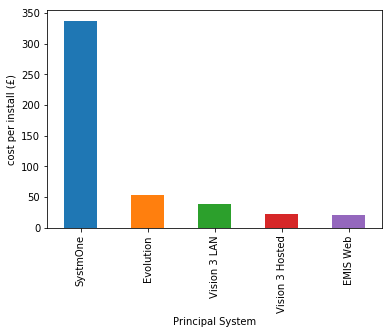

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt 
summary['cost_per_install'].plot.bar()
plt.ylabel("cost per install (£)")

# Create useful files for CCGs

In [51]:
summary = gpd_ghost_df.assign(saving_from_top_10 = None).set_index('ccg_id')
import re
import os
from zipfile import ZipFile
for ccg_id in summary.index:
    if re.match(r"^[0-9]{2}[A-Z]", ccg_id):
        ccg = ghost_df[ghost_df.ccg_id == ccg_id]
        top_presentations = ccg.groupby('bnf_description').sum().sort_values('excess_cost_dt', ascending=False).head(10).reset_index()[['bnf_description', 'excess_cost_dt']]
        target_prescriptions = top_presentations.merge(ccg, how='left', left_on='bnf_description', right_on='bnf_description').sort_values('excess_cost_dt_y', ascending=False)
        useful_cols = ['practice_code', 'bnf_description', 'bnf_code', 'items', 'excess_cost_dt_y']
        target_prescriptions = target_prescriptions[useful_cols]
        target_prescriptions = target_prescriptions.groupby(['practice_code', 'bnf_description', 'bnf_code']).sum().reset_index()
        target_prescriptions.columns = ['practice_code', 'bnf_description', 'bnf_code', 'items', 'excess_cost']
        summary.loc[ccg_id, 'saving_from_top_10'] = target_prescriptions['excess_cost'].sum()
        f = "{}.csv".format(ccg_id)
        target_prescriptions.to_csv(f)
        with ZipFile("csv_data/{}.zip".format(ccg_id), 'w') as myzip:
            myzip.write(f)
        os.remove(f)
summary = summary.reset_index()

In [33]:
summary.head()

,ccg_id,excess_cost_dt,saving_from_top_10
0,06H,36167.2935,12914.2
1,15F,26294.4252,11122.2
2,15E,25910.4207,12003.7
3,11J,24356.5480,10649
4,05L,22655.0496,9381.82
